In [1]:
#%%
from lambeq import BobcatParser
from discocirc.closed import Func
from discocirc.sentence_to_circuit import make_term, make_diagram, sentence2circ
from discocirc.pulling_out import is_higher_order
from discocirc.term import Term
from discocirc.frame import Frame

#%%
parser = BobcatParser()
draw_term = lambda term: (Frame.get_decompose_functor())(make_diagram(term)).draw(figsize=(6, 10))


/Users/richie/Documents/work/discoket/lambeq/text2diagram/ccg_parser.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def just(term):
    return Term(term.name, term.simple_type, term.simple_type, [])


def pop(term):
    args, h = term.args[:-1], term.args[-1]
    final_type = h.final_type >> term.final_type
    g = Term(term.name, term.simple_type, final_type, args)
    assert term == g(h)
    return g, h


def thrush(f, g, h):
    typs = []
    t = f.simple_type
    for _ in f.args:
        typs.insert(0, t.input)
        t = t.output
    t = (h.final_type >> t.input) >> (h.final_type >> t.output)
    final_type = t
    for typ in typs:
        t = typ >> t
    return Term(f.name, t, final_type, f.args), g, h


def exch_t(term, i, n):
    typs = []
    t = term.simple_type
    for _ in range(n):
        typs.insert(0, t.input)
        t = t.output
    t = typs[i] >> t
    for j, typ in enumerate(typs):
        if j != i:
            t = typ >> t
    return Term(term.name, t, t, [])


def exch(term, i):
    g = exch_t(term, i, len(term.args))
    args = term.args
    for j, arg in enumerate(term.args):
        if j != len(args) - i - 1:
            g = g(arg)
    g = g(args[len(args) - i - 1])
    return g

In [3]:
def check(f, g, h):
    # don't pull out higher order diagrams
    if isinstance(h.final_type, Func):
        return False
    # only pull out from a higher order box:
    if not is_higher_order(f.final_type):
        return False
    return True


def pull_out(term):
    f = just(term)
    for arg in term.args:
        new_arg = pull_out(arg)
        put_back = True
        for i in range(len(new_arg.args)):
            try_arg = exch(new_arg, i)
            g, h = pop(try_arg)
            if check(f, g, h):
                f, g, h = thrush(f, g, h)
                f = pull_out(f(g))(h)
                put_back = False
                break

        if put_back:
            f = f(new_arg)
    return f

In [4]:
# sentences = [
#     "Alice quickly passionately gives Bob red flowers and blue smelly cheese",
#     "Alice is very sleepy and Bob is very sleepy",
#     "Alice quickly gives Claire red smelly fish",
#     "Alice quickly and passionately sleeps"
# ]
sentences = [
 'Alice quickly gives flowers',
 'Alice quickly eats',
#  'Alice who Bob likes walks',  # (composition)
 'Alice gives flowers with Bob',
 'Alice gives flowers to Bob',
 'Alice quickly loves very red Bob',
 'Alice fully loves Bob',
 'Alice quickly eats',
 'Alice quickly eats fish',
 'Alice quickly eats red fish',
 'Alice quickly loves very red Bob',
 'Alice quickly rapidly loudly loves very very red Bob',
 'Alice quickly and rapidly loves Bob and very red Claire',
 'I know of Alice loving and hating Bob',
#  'I surely know certainly of Alice quickly loving Bob',  # (composition)
 "Alice knows of Bob liking Claire and Dave hating Eve",
 'Alice knows that Bob loves Claire',
 'Alice runs',
 'Alice runs to the kitchen',
 'Alice knows that Bob loves Claire, Claire hates Bob',
 'Alice loves Bob and Claire loves Dave',
 'Alice loves Bob and Bob loves Claire',
 'Alice knows that Bob loves Claire',
 'The lawyers went to work',
 'Before he went to the treasury',
 'I know of Alice loving Bob',
 'I know of Alice quickly loving Bob',
#  'I know certainly of Alice quickly loving Bob',  # (composition)
 'I know that Alice hates Bob and Claire loves Dave',
 'Alice loves Bob and Claire hates Dave',
 'Alice knows that Bob loves Claire',
 'Alice quickly loves and hates Bob',
 'I dreamt that Alice went to the shop and bought ice cream',
#  'Bob likes flowers that Claire picks',  # (composition)
]


trees = [parser.sentence2tree(sentence).to_biclosed_diagram() for sentence in sentences]
terms = [make_term(tree) for tree in trees]

In [5]:
from copy import deepcopy
from discocirc.pulling_out import recurse_pull

In [6]:
def validate(term):
    f = just(term)
    for arg in term.args:
        if not validate(arg):
            return False
        f = f(arg)
    return term == f


def simple_match(term1, term2):
    for arg1, arg2 in zip(term1.args, term2.args):
        if not simple_match(arg1, arg2):
            return False
    return (term1.name, term1.simple_type) == (term2.name, term2.simple_type)

In [7]:
cnt = 0
for sent, term in zip(sentences, terms):
    a = pull_out(term)
    b = deepcopy(term)
    recurse_pull(b)
    assert validate(a)
    if not validate(b):
        cnt += 1
    if not simple_match(a, b):
        print(sent)
        draw_term(a)
        draw_term(b)
        break

print(f"Invalid terms from recurse_pull: {cnt} out of {len(terms)}")

Invalid terms from recurse_pull: 25 out of 30


In [8]:
%timeit [pull_out(term) for term in terms]

6.42 ms ± 78.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%timeit [recurse_pull(deepcopy(term)) for term in terms]

16 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit [deepcopy(term) for term in terms]

12.1 ms ± 857 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Alice quickly gives flowers


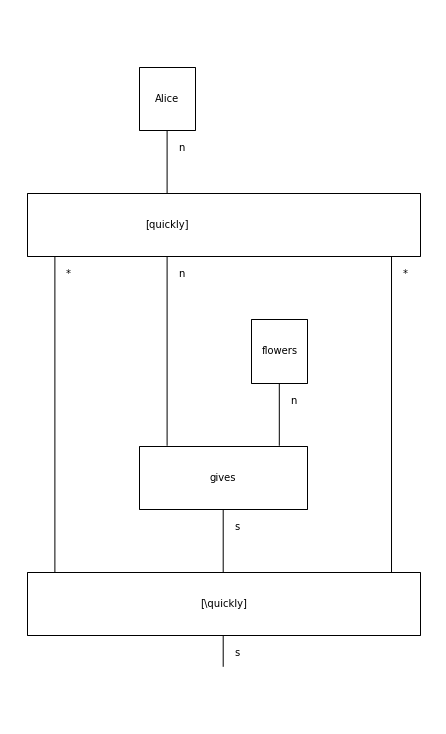

Alice quickly eats


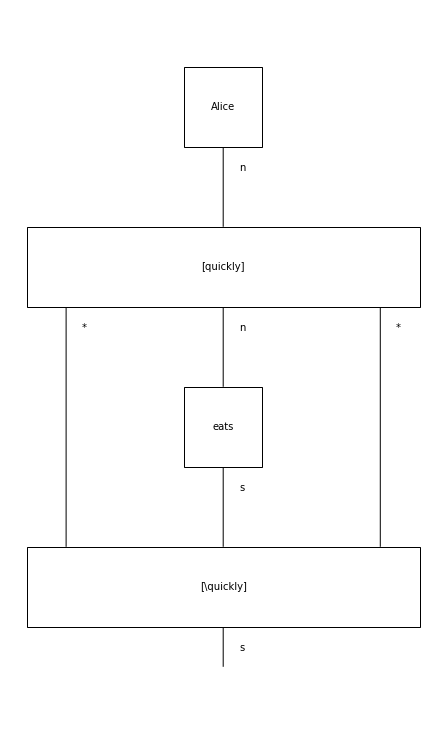

Alice gives flowers with Bob


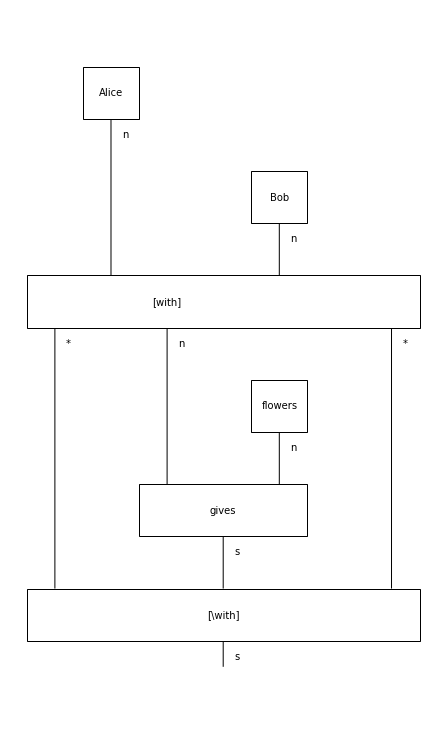

Alice gives flowers to Bob


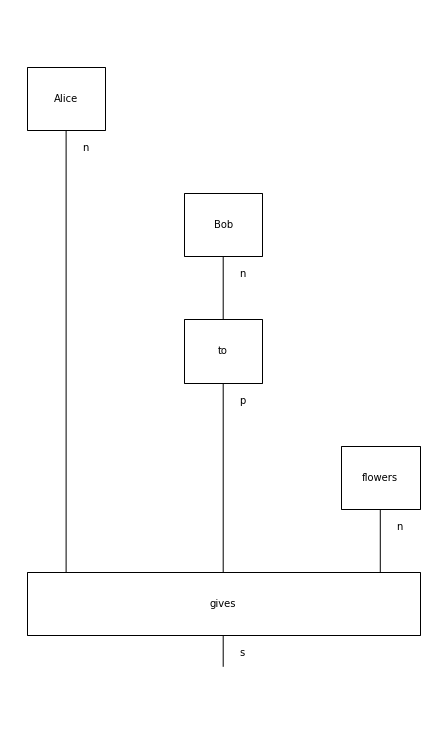

Alice quickly loves very red Bob


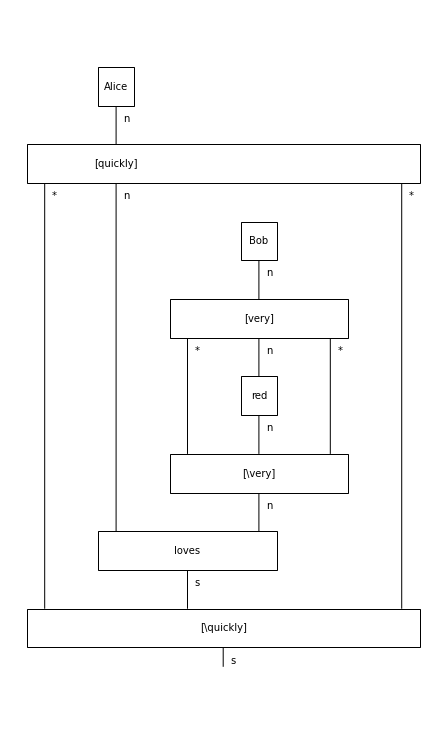

Alice fully loves Bob


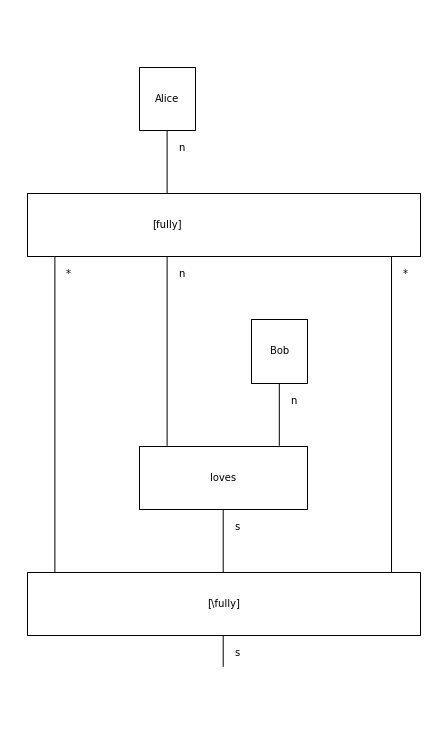

Alice quickly eats


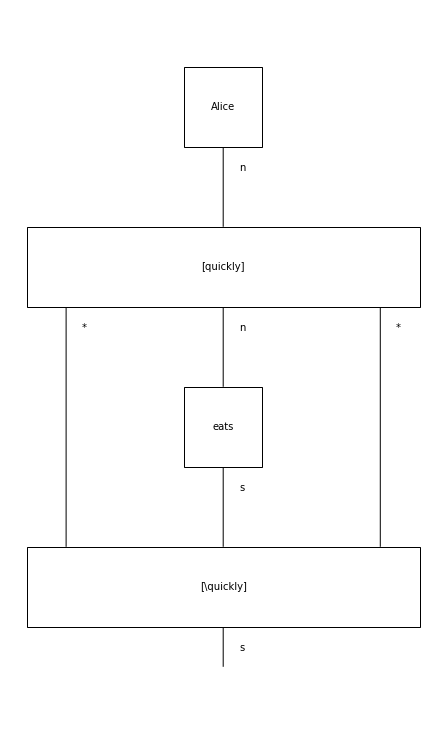

Alice quickly eats fish


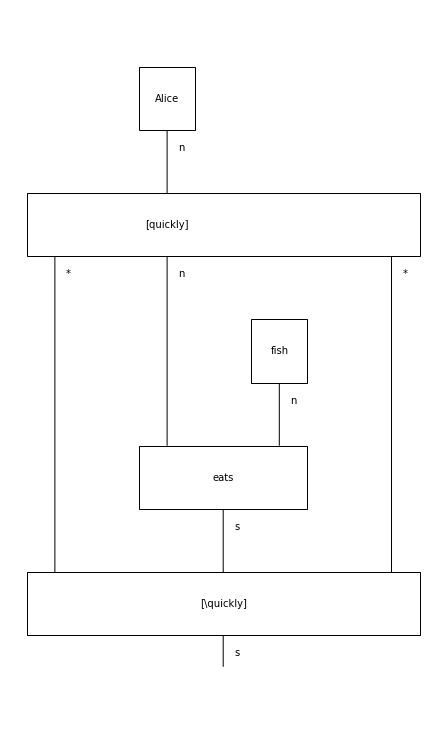

Alice quickly eats red fish


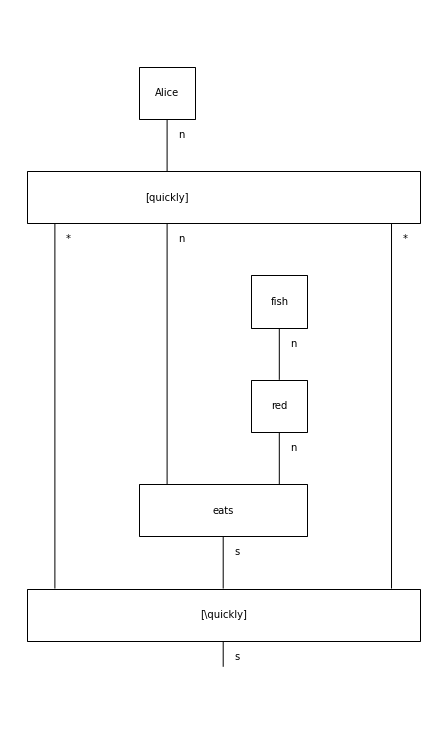

Alice quickly loves very red Bob


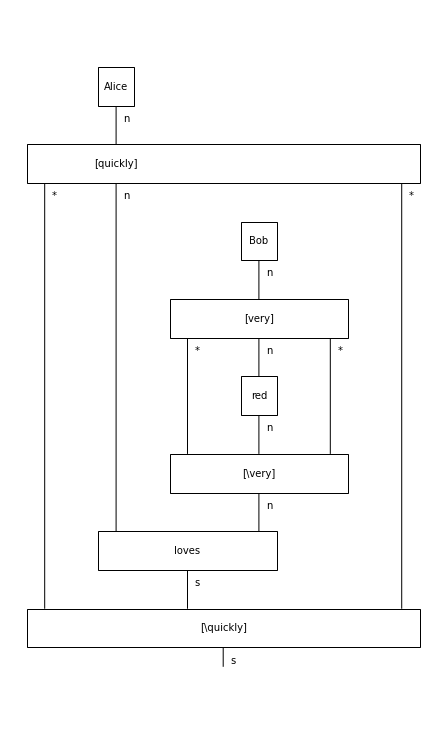

Alice quickly rapidly loudly loves very very red Bob


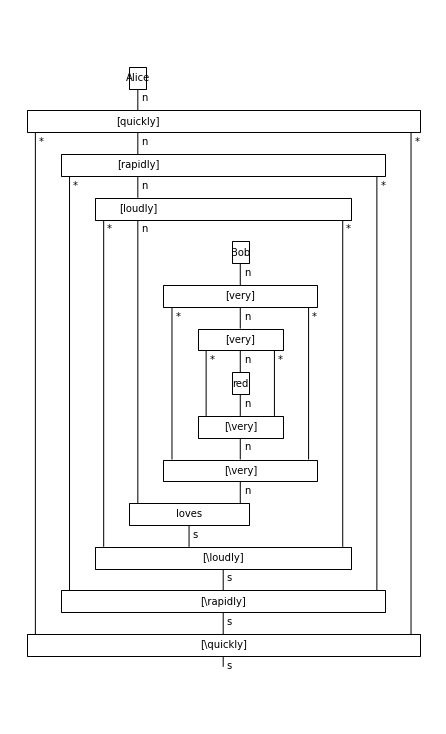

Alice quickly and rapidly loves Bob and very red Claire


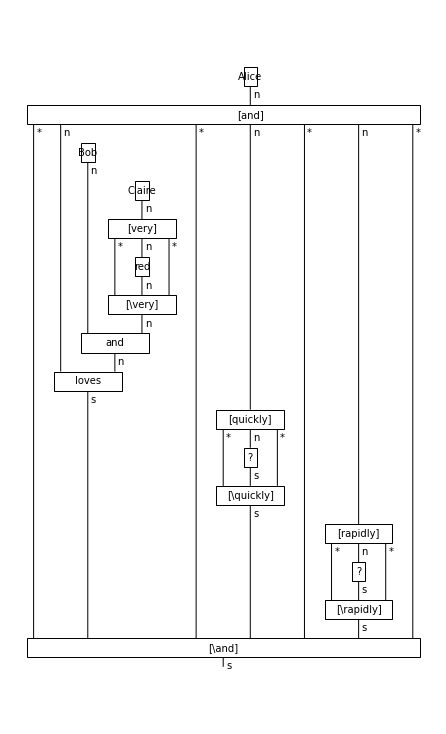

I know of Alice loving and hating Bob


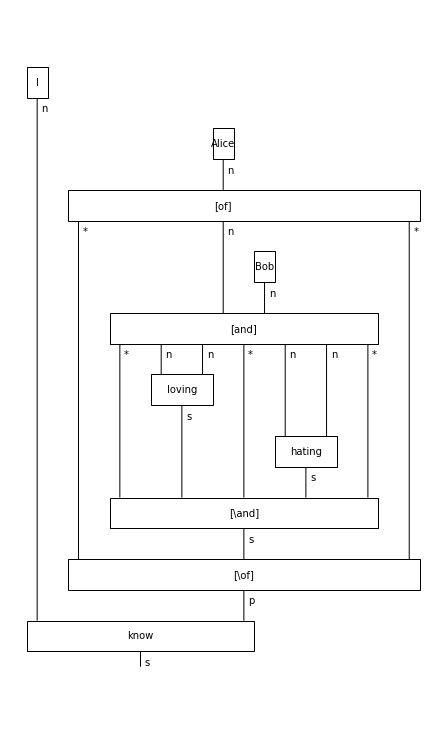

Alice knows of Bob liking Claire and Dave hating Eve


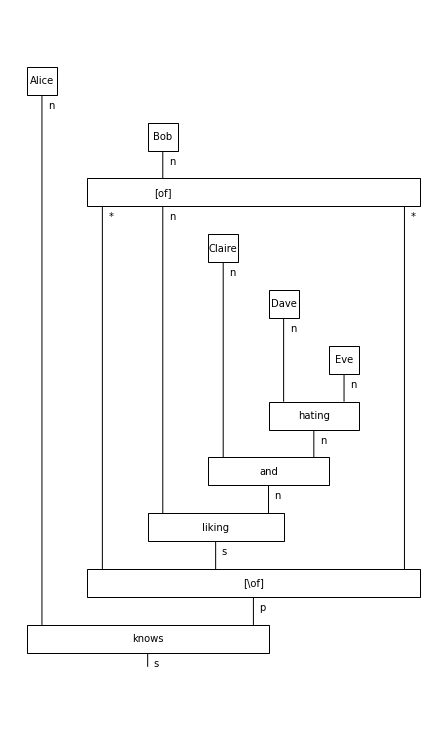

Alice knows that Bob loves Claire


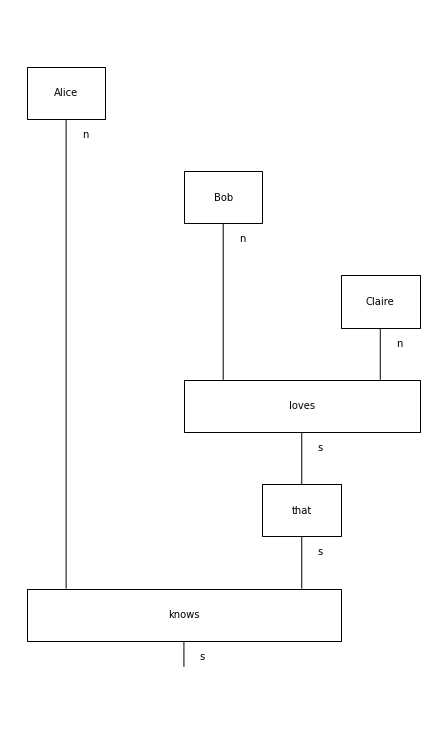

Alice runs


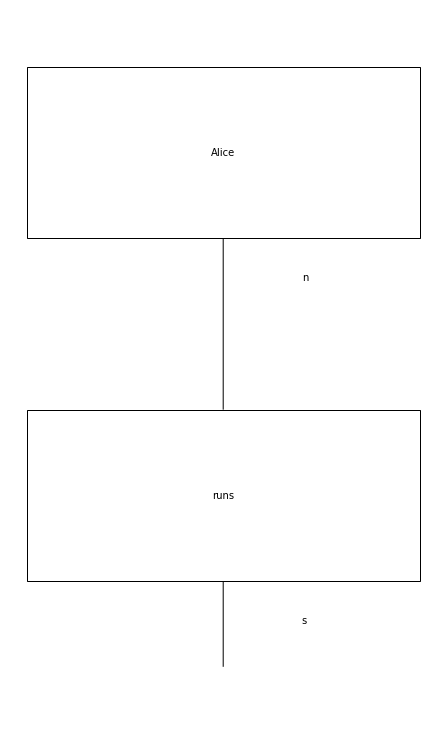

Alice runs to the kitchen


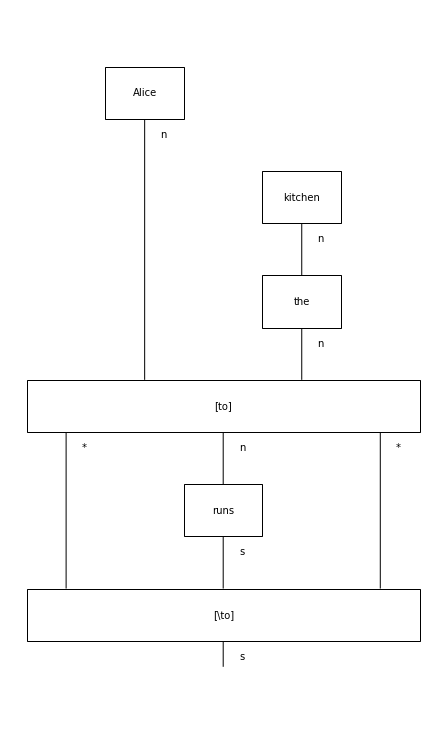

Alice knows that Bob loves Claire, Claire hates Bob


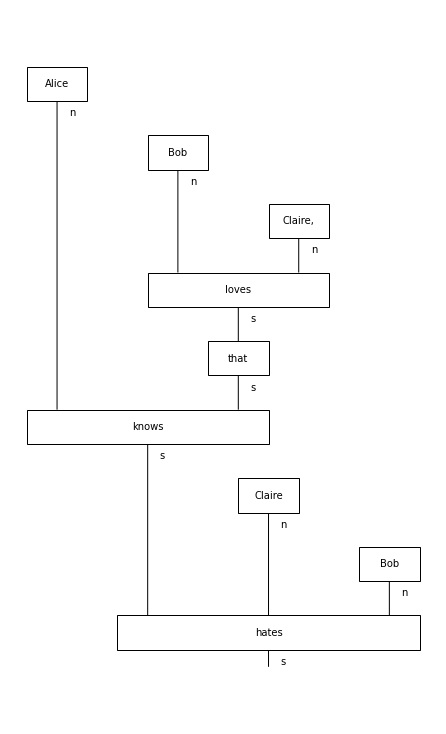

Alice loves Bob and Claire loves Dave


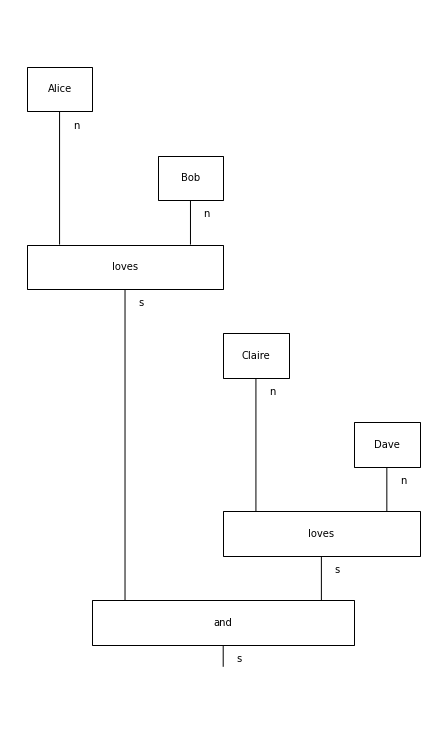

Alice loves Bob and Bob loves Claire


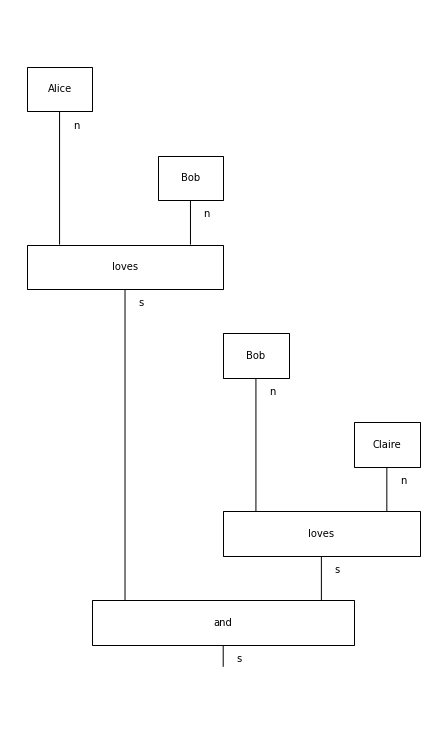

Alice knows that Bob loves Claire


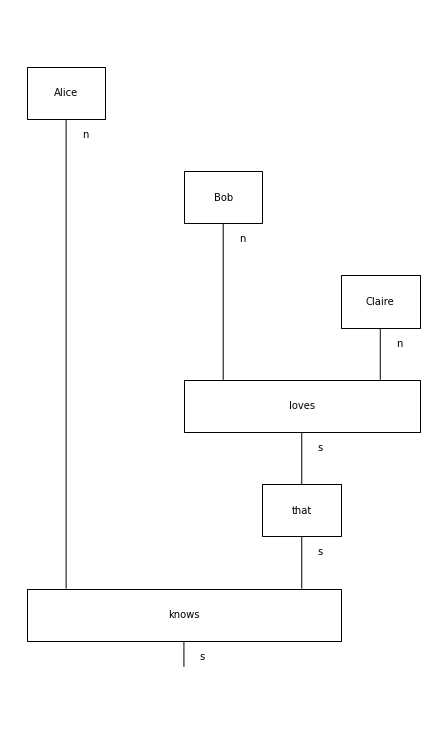

The lawyers went to work


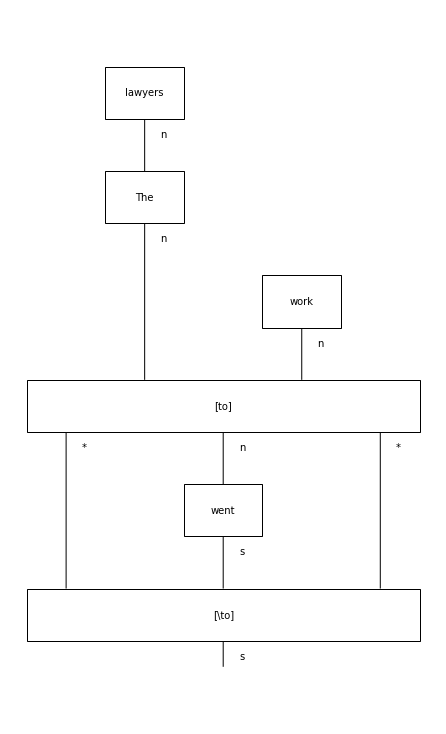

Before he went to the treasury


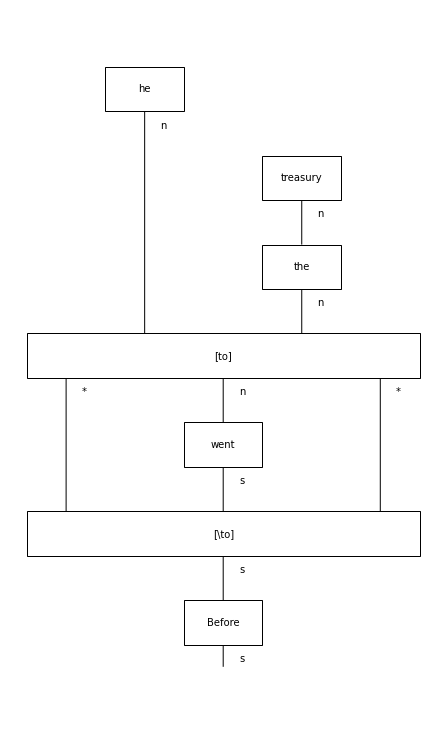

I know of Alice loving Bob


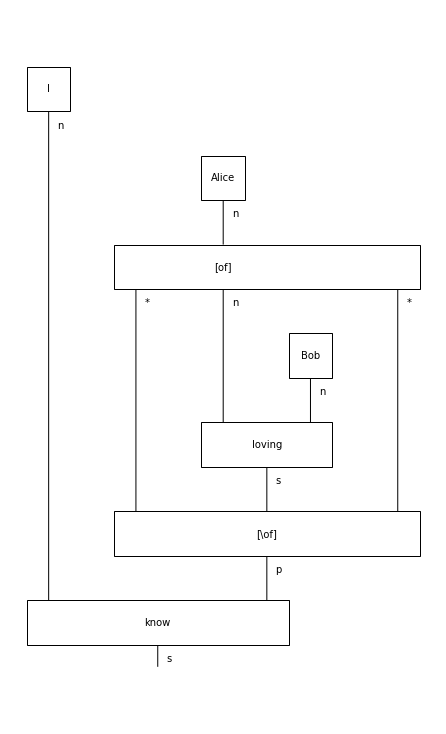

I know of Alice quickly loving Bob


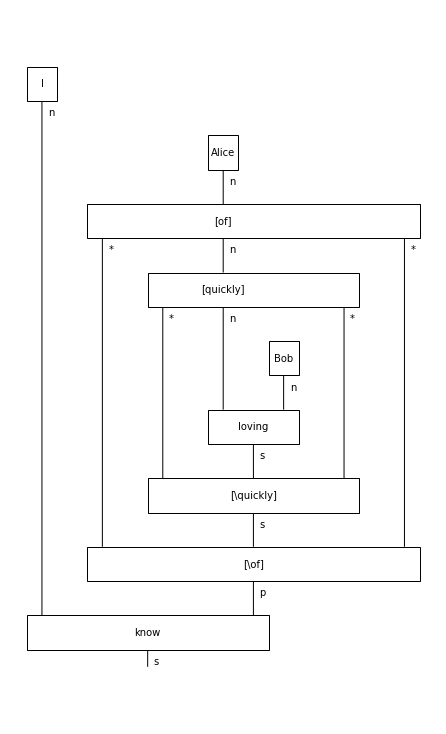

I know that Alice hates Bob and Claire loves Dave


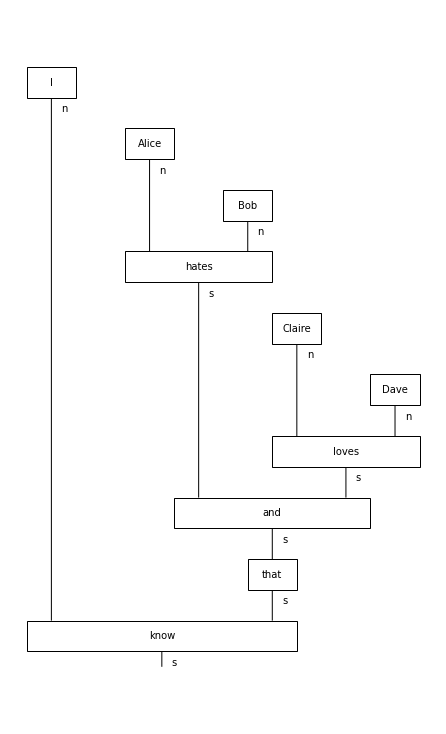

Alice loves Bob and Claire hates Dave


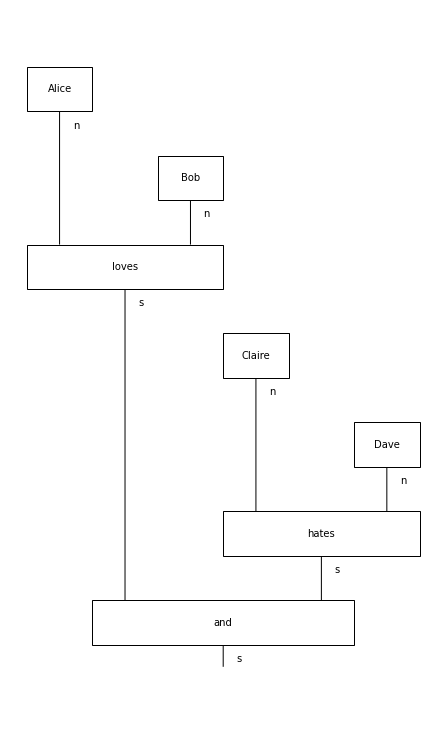

Alice knows that Bob loves Claire


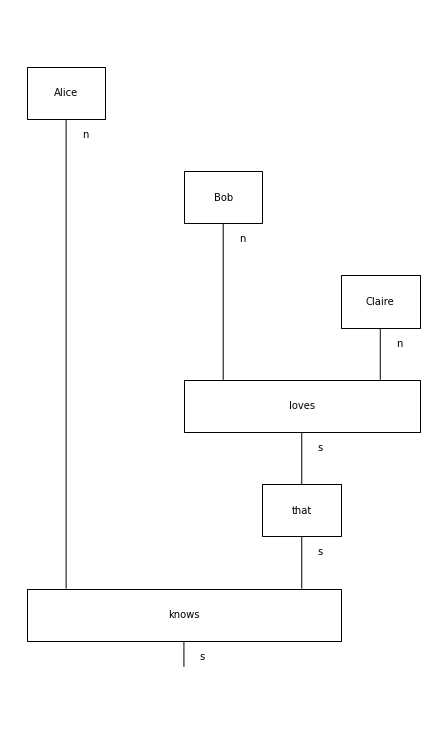

Alice quickly loves and hates Bob


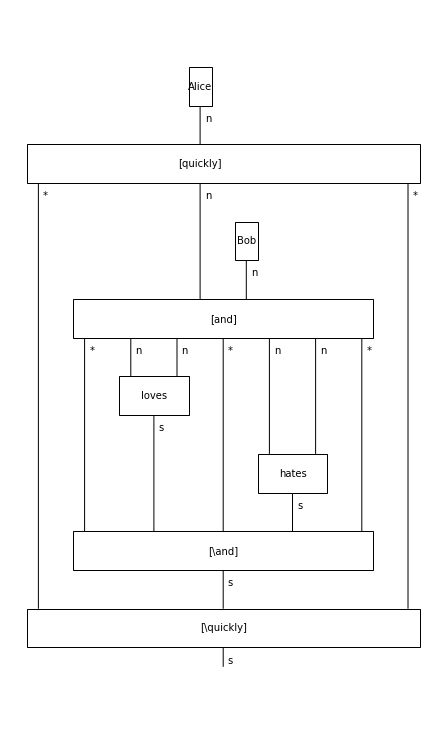

I dreamt that Alice went to the shop and bought ice cream


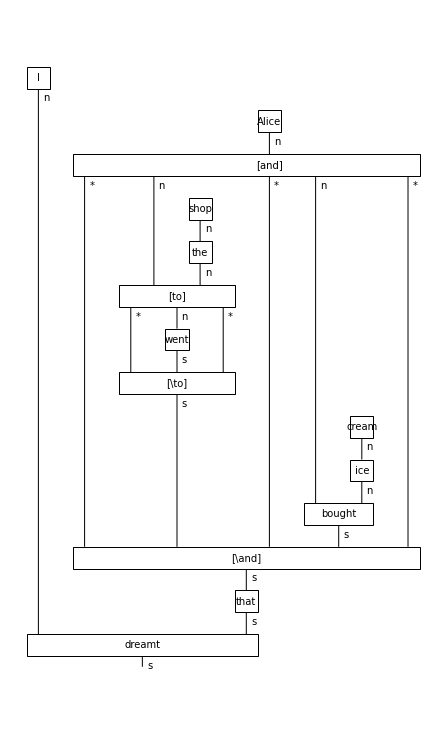

In [11]:
for sent, term in zip(sentences, terms):
    print(sent)
    draw_term(term)
    